In [3]:
import polars as pl
import geopandas as gpd
from pathlib import Path
import folium
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

# Data Load

First, we read in the shapefile for the gridcell covariates.

We will be using EPSG 3174 for the Great Lakes coordinate system, followed by EPSG:4326 for plotting.

See https://epsg.io/3174 and https://epsg.io/4326

try epsg 2163 - clear outputs

In [4]:
bat_covars = gpd.read_file("data/data/NABat_grid_covariates/NABat_grid_covariates.shp")
stations = pd.read_excel("data/data/USFWS_Bat_Acoustic_Data/Metadata.xlsx", sheet_name='AcousticSites')
pass_counts = pd.read_excel("data/data/USFWS_Bat_Acoustic_Data/NightlyPassCounts.xlsx")
water_bodies = gpd.read_file("data/data/USA_Detailed_Water_Bodies/USA_Detailed_Water_Bodies.shp")
lakes = gpd.read_file("data/data/rivers_and_lakes_shapefile/NA_Lakes_and_Rivers/data/lakes_p/northamerica_lakes_cec_2023.shp")
rivers = gpd.read_file("data/data/rivers_and_lakes_shapefile/NA_Lakes_and_Rivers/data/rivers_l/northamerica_rivers_cec_2023.shp")


<Axes: >

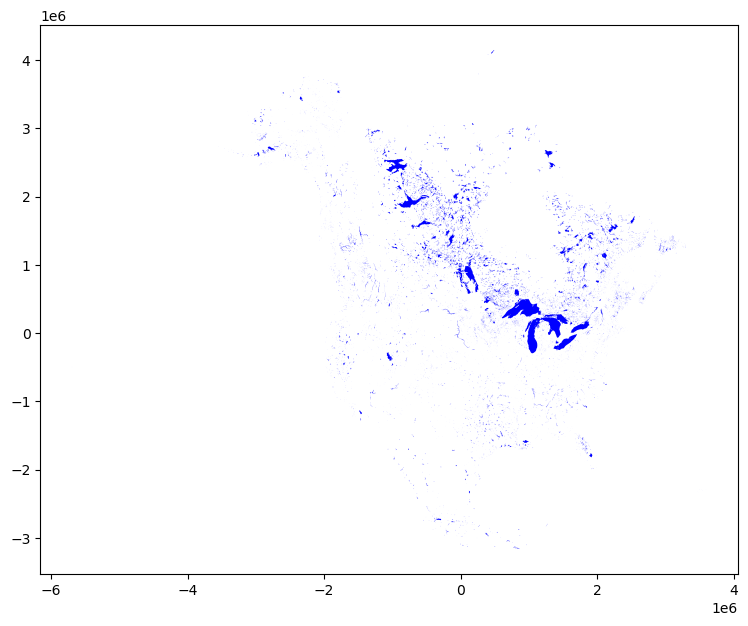

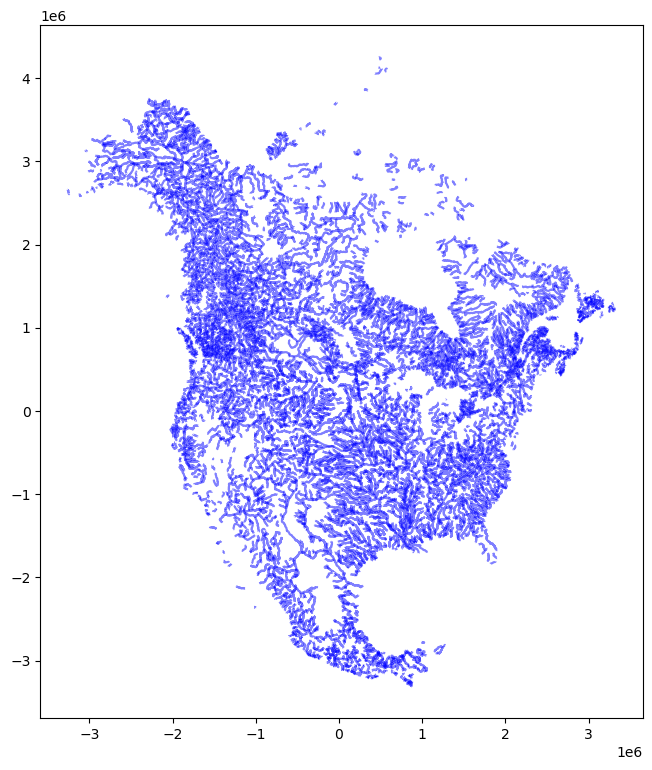

In [30]:
lakes = lakes.to_crs(epsg=2163)
rivers = rivers.to_crs(epsg=2163)

lakes.plot(figsize=(9, 9), color="blue")
rivers.plot(figsize=(9, 9), alpha=0.5, color="blue")

<Axes: >

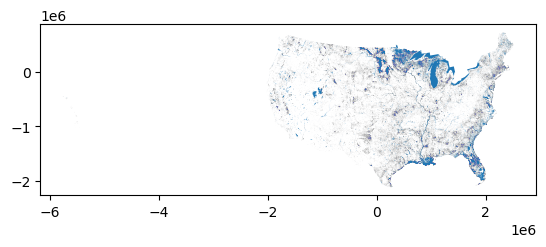

In [31]:
water_bodies = water_bodies.to_crs(epsg=2163)

water_bodies.plot()
# water_bodies.head()
# water_bodies = water_bodies[water_bodies["SQKM"] > 1.0]
# all_water_bodies = gpd.GeoDataFrame(all_water_bodies, geometry='geometry')


In [32]:
all_water_bodies = gpd.GeoDataFrame(pd.concat([
    water_bodies,
    lakes,
    rivers
], axis=0, ignore_index=True), geometry='geometry')

all_water_bodies["NAME"] = all_water_bodies["NAME"].combine_first(all_water_bodies["NameEn"]).combine_first(all_water_bodies["NameEs"]).combine_first(all_water_bodies["NameFr"]).fillna("Unknown")
all_water_bodies.head()


,OBJECTID,NAME,FTYPE,FCODE,FCODE_DESC,SQKM,SQMI,geometry,Country,Type,NameEn,NameEs,NameFr,AreaSqKm,LengthKm
0,1.0,Unknown,Canal/Ditch,33600.0,Canal/Ditch,0.13,0.05,"POLYGON ((-5604792.696 -669356.956, -5604800.5...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,Unknown,Lake/Pond,39004.0,Lake/Pond: Hydrographic Category = Perennial,0.02,0.01,"POLYGON ((-5615864.915 -647942.885, -5615832.0...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,Unknown,Lake/Pond,39004.0,Lake/Pond: Hydrographic Category = Perennial,0.02,0.01,"POLYGON ((-5617034.31 -646901.027, -5617071.23...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,Unknown,Lake/Pond,39004.0,Lake/Pond: Hydrographic Category = Perennial,0.02,0.01,"POLYGON ((-5617546.926 -648668.992, -5617533.9...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,Unknown,Lake/Pond,39004.0,Lake/Pond: Hydrographic Category = Perennial,0.39,0.15,"POLYGON ((-5591987.865 -665832.81, -5591998.47...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
all_water_bodies.columns

Index(['OBJECTID', 'NAME', 'FTYPE', 'FCODE', 'FCODE_DESC', 'SQKM', 'SQMI',
       'geometry', 'Country', 'Type', 'NameEn', 'NameEs', 'NameFr', 'AreaSqKm',
       'LengthKm'],
      dtype='object')

<Axes: >

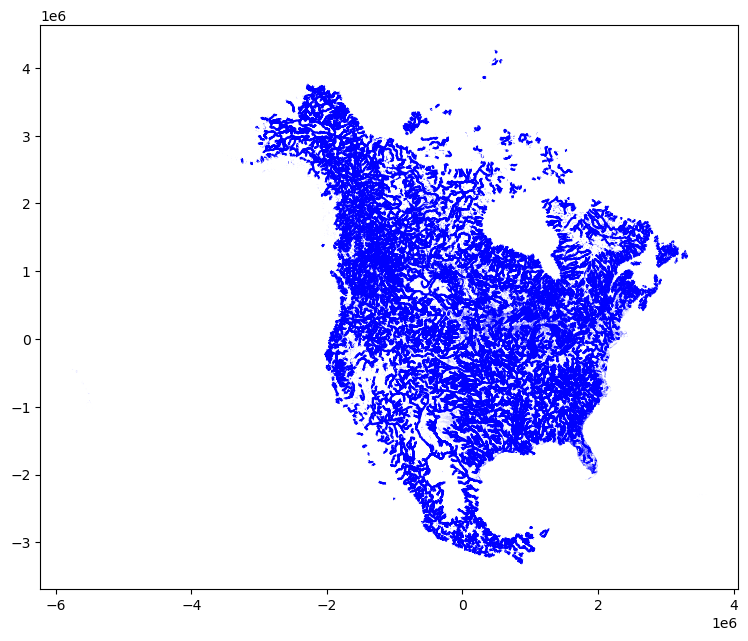

In [34]:
all_water_bodies.plot(figsize=(9, 9), color="blue")

In [35]:
stations["geometry"] = gpd.points_from_xy(stations["Long"], stations["Lat"], crs="EPSG:4326").to_crs(epsg=2163)
stations = gpd.GeoDataFrame(stations, geometry='geometry')

Now, merge the two datasets together.

<Axes: >

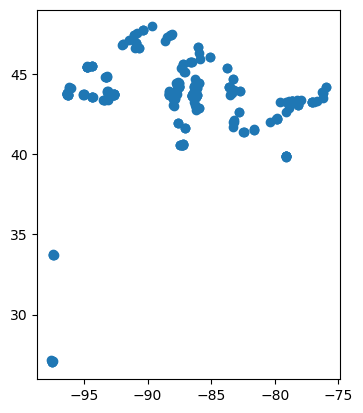

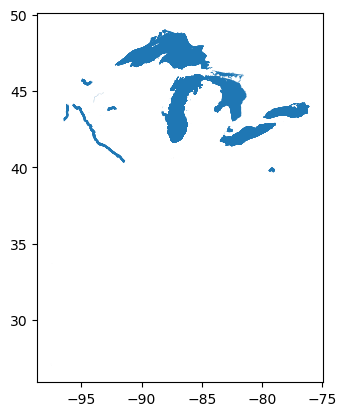

In [36]:
station_plus_water = (
    gpd.sjoin_nearest(
        stations, all_water_bodies, how="left", distance_col="dist_to_water", rsuffix="_water"
    )
    .sort_values("dist_to_water", ascending=False)
    .groupby("AcousticSite")
    .nth(0)
)

nearest_water = all_water_bodies.loc[station_plus_water["index__water"]]

# station_plus_water = station_plus_water.set_geometry("geometry")

station_plus_water = station_plus_water.to_crs("EPSG:4326")
station_plus_water.plot()

water_geom = nearest_water[["NAME", "geometry"]].to_crs("EPSG:4326")
water_geom.plot()


In [ ]:
station_plus_water.to_csv("./station_plus_water.csv", index=False)

In [ ]:
if True:
    m = folium.Map(zoom_start=4, location=[38.5, -90.0])
    plotted_geoms = set()
    i = 0
    for (row, water_geo) in zip(station_plus_water.iterrows(), water_geom.iterrows()):

        # print(i)
        _, r = row
        _, w = water_geo
        poly_dat = gpd.GeoSeries(r["geometry"]).to_json()

        water_dat = gpd.GeoSeries(w["geometry"]).to_json()
        geo_j = folium.GeoJson(data=poly_dat)
        water_j = folium.GeoJson(data=water_dat)
        info = pd.DataFrame(
            r[["AcousticSite", 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, "dist_to_water", "NAME"]],
        ).to_html()

        w_info = w["NAME"]

        folium.Popup(info).add_to(geo_j)
        folium.Popup(w_info).add_to(water_j)

        geo_j.add_to(m)
        if water_dat not in plotted_geoms:
            water_j.add_to(m)
            plotted_geoms.add(water_dat)

        i += 1
        if i % 50 == 0:
            print(f"{i} ({i/len(station_plus_water)*100:.0f}%)")
        

    m.save("bat_maps_distance.html")

In [ ]:
m

In [ ]:
station_plus_water = station_plus_water.reset_index()
station_plus_water["water_geom"] = water_geom.reset_index()["geometry"]

In [ ]:
water_body_size = (
    station_plus_water["SQKM"]
    .combine_first(station_plus_water["AreaSqKm"])
    .combine_first(station_plus_water["LengthKm"])
)


station_water_metadata = (
    station_plus_water.assign(water_size=water_body_size)[
        [
            "AcousticSite",
            "Lat",
            "Long",
            "geometry",
            2010,
            2011,
            2012,
            2013,
            2014,
            2015,
            2016,
            2017,
            2018,
            "EPTFUS",
            "LASBOR",
            "LASCIN",
            "LASNOC",
            "MYOLUC",
            "MYOSEP",
            "PERSUB",
            "MYOLEI",
            "MYOSOD",
            "NYCHUM",
            "CORRAF",
            "ANTPAL",
            "LASINT",
            "TADBRA",
            "dist_to_water",
            "NAME",
            "water_size",
            "water_geom",
        ]
    ]
    .rename(
        {
            "NAME": "water_name",
            2010: "nights_2010",
            2011: "nights_2011",
            2012: "nights_2012",
            2013: "nights_2013",
            2014: "nights_2014",
            2015: "nights_2015",
            2016: "nights_2016",
            2017: "nights_2017",
            2018: "nights_2018",
        },
        axis=1,
    )
)

station_water_metadata.to_csv("./data/data/stations_with_water.csv", index=True)
station_water_metadata.head()

In [ ]:
bat_counts = pl.read_excel("data/data/USFWS_Bat_Acoustic_Data/NightlyPassCounts.xlsx")
bat_counts.columns

In [ ]:
bat_count_agg = (
    bat_counts.group_by_dynamic("NightOf", every="1y", group_by="AcousticSite")
    .agg(
        pl.col(
            "ALL",
            "EPTFUS",
            "LASBOR",
            "LASCIN",
            "LASNOC",
            "MYOLUC",
            "MYOSEP",
            "PERSUB",
            "MYOLEI",
            "MYOSOD",
            "NYCHUM",
            "CORRAF",
            "ANTPAL",
            "LASINT",
            "TADBRA",
        ).sum()
    )
    .with_columns(pl.col("NightOf").dt.year().alias("Year"))
    .to_pandas()
)
bat_count_agg

In [ ]:
station_water_metadata

all_bat_maps = pd.merge(
    bat_count_agg,
    station_water_metadata,
    left_on="AcousticSite",
    right_on="AcousticSite",
    how="left",
    suffixes=("_count", "_meta"),
)
all_bat_maps

In [ ]:
m = folium.Map(zoom_start=4, location=[38.5, -90.0])
i = 0
plotted_water = set()
for station, df in all_bat_maps.groupby("AcousticSite"):
    water_json = gpd.GeoSeries(data=df["water_geom"].iloc[0]).set_crs("EPSG:4326").to_json()
    geo_j = folium.GeoJson(gpd.GeoSeries(data=df["geometry"].iloc[0]).to_json())
    water_j = folium.GeoJson(water_json)

    # Create HTML block -- CoPilot
    top_level_info = f"""
    <div>
        <h4>{df["AcousticSite"].iloc[0]}</h4>
        <p><strong>Distance to Water:</strong> {df["dist_to_water"].iloc[0]:0.0f}</p>
        <p><strong>Water Name:</strong> {df["water_name"].iloc[0]}</p>
        <ul>
    """
    for _, row in df.iterrows():
        top_level_info += f"<li>{row['Year']}: {row['ALL']}</li>"
    top_level_info += "</ul></div>"

    geo_info = top_level_info
    w_info = df["water_name"].iloc[0]

    folium.Popup(geo_info, max_width=200).add_to(geo_j)
    folium.Popup(w_info, max_width=200).add_to(water_j)

    geo_j.add_to(m)

    if water_json not in plotted_water:
        water_j.add_to(m)
        plotted_water.add(water_json)

    i += 1


In [ ]:
m.save("bat_counts.html")
m

In [ ]:
all_bat_maps.to_csv("data/data/annual_bat_counts.csv", index=False)


In [ ]:
all_bat_maps.head()